In [2]:
import pandas as pd
LocationDescriptions = pd.read_csv('LocationDescriptions.csv', index_col = 'Name')
LocationDescriptions

,Engine Position,Location Position
Name,,
Logger1,Engine 1,IC Cleaner
Logger2,Engine 1,Toning Station
Logger3,Engine 1,Return Outlet
Logger4,Engine 1,BC Roller Return Side
Logger5,Engine 2,IC Cleaner
Logger6,Engine 2,Toning Station
Logger7,Engine 2,Return Outlet
Logger8,Engine 2,BC Roller Return Side
Logger9,Engine 3,IC Cleaner


In [3]:
LocationDescriptions.loc['Logger6', 'Engine Position']

'Engine 2 '

In [4]:
from pathlib import Path
dataFolder = '26Jul'
filePath = Path(r'C:\Users\TonyWitt\OneDrive - Evolve\Documents\Flir Logs')
filePath = filePath/dataFolder
roomData = pd.read_csv(filePath/'RIC_ROOM_REFERENCE-TempRH--.csv', skiprows=range(1,140000), parse_dates=['Date/Time'])
roomData['roomTemp'] = (roomData['Temperature (F)'] -32) * (5/9)
roomData['epocTime'] = roomData['Date/Time'].astype('int64')//1e9
roomData['epocTime'].iloc[100]

1658833653.0

In [5]:
roomData['roomTemp'] = (roomData['Temperature (F)'] -32) * (5/9)
roomData['epocTime'] = roomData['Date/Time'].astype('int64')//1e9
roomData.iloc[100]

Date/Time          2022-07-26 05:07:33-06:00
Temperature (F)                    69.196082
Moisture (%)                       54.333252
Battery (Volts)                     3.056549
roomTemp                            20.66449
epocTime                        1658833653.0
Name: 100, dtype: object

In [6]:
#use this for new path thing
jobsData = pd.read_csv('jobsData.csv', index_col='Date')
job = jobsData.loc['July26', 'Path']
job = Path(job)
dataLocation = pd.read_csv(job/'syncedData.csv')

C:\Users\TonyWitt\AppData\Local\Temp\ipykernel_46172\3974202665.py:5: DtypeWarning: Columns (9,86) have mixed types. Specify dtype option on import or set low_memory=False.
  dataLocation = pd.read_csv(job/'syncedData.csv')


In [7]:
# trying to get only the job data. Should be cleaner
syncedData = pd.read_csv('syncedData.csv')
squareData = syncedData[['Time','EPTemp', 'EPHumidity','ECSReturnTemp', 'ECSReturnHumidity','ECSSupplyTemp','ECSSupplyHumidity']]
#get rid of extra space
squareData = squareData[squareData['Time'].notnull()]
jobEndTime = squareData['Time'].max()
#create filter to get only job data for loggers
#need loop for all loggers
for i in range(19):
    #create filter to get only job data for loggers
    timeFilter = (syncedData[f'Logger{i+1}Time'] > 0) & (syncedData[f'Logger{i+1}Time'] < jobEndTime)
    #apply filter to the 3 columns assc with the logger
    filteredLoggerData = syncedData.loc[timeFilter,[f'Logger{i+1}Time',f'Logger{i+1}Temp',f'Logger{i+1}Humidity']].reset_index()
    squareData = pd.concat([squareData, filteredLoggerData],axis=1)
#new filter for room data
timeFilter = (syncedData['roomTime'] > 0) & (syncedData['roomTime'] < jobEndTime)
#apply filter to the 3 columns assc with room reference
filteredRoomData = syncedData.loc[timeFilter,['roomTime','roomTemp','roomHumidity']].reset_index()
squareData = pd.concat([squareData, filteredRoomData],axis=1)
squareData.to_csv('squareData.csv')

C:\Users\TonyWitt\AppData\Local\Temp\ipykernel_46172\92685600.py:2: DtypeWarning: Columns (9,86) have mixed types. Specify dtype option on import or set low_memory=False.
  syncedData = pd.read_csv('syncedData.csv')


In [31]:
#new data with only max temps per job
jobsData = pd.read_csv('jobsData.csv', index_col='Job')
#input
jobInput = 1659450636

job = jobsData.loc[jobInput, 'Path']
filePath = Path(job)
squareData = pd.read_csv(filePath/'squareData.csv')
concatDataByJob = pd.read_csv('concatDataByJob.csv')

columnlist = []
loggerNameList =[]
loggerAttributeList = []
for column in squareData.columns:
    if 'Temp' in column or 'Humidity' in column:
        columnlist.append(column)
temporaryMax = squareData[columnlist].max()
temporaryAverage = squareData[columnlist].mean()
for logger in temporaryMax.index:
    if 'Temp' in logger:
        loggerNameList.append(logger.split('Temp')[0])
        loggerAttributeList.append('Temp')
    elif 'Humidity' in logger:
        loggerNameList.append(logger.split(('Humidity'))[0])
        loggerAttributeList.append('Humidity')

dataByJob = pd.DataFrame(
    {'LoggerName':loggerNameList,
    'AttributeType' : loggerAttributeList,
    'AverageValue': temporaryAverage.values,
    'MaxValue': temporaryMax.values,
    'Job':[jobInput]*len(loggerAttributeList)})

concatDataByJob = pd.concat([concatDataByJob,dataByJob])
concatDataByJob.to_csv('concatDataByJob.csv',index=False)

<AxesSubplot:xlabel='LoggerName'>

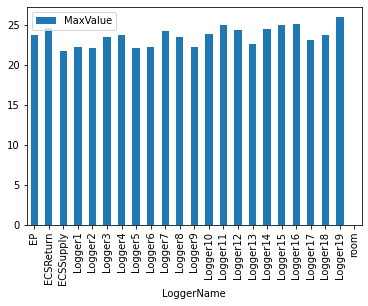

In [9]:
plotDataByJob= dataByJob.loc[(dataByJob['AttributeType'] == 'Temp')]
plotDataByJob.plot(x='LoggerName',y='MaxValue',kind = 'bar')

<BarContainer object of 1 artists>

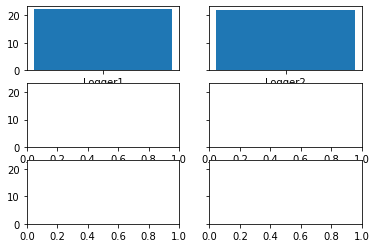

In [11]:
import matplotlib.pyplot as plt
import referenceVariable
df = plotDataByJob
fig, axs = plt.subplots(3,2, sharey=True)
filt = df['LoggerName']=='Logger1'
filt
axs[0, 0].bar('LoggerName','MaxValue', data=df[filt], label='Control')
axs[0, 1].bar('LoggerName','MaxValue', data=df[df['LoggerName']=='Logger2'],label ='Control')

In [33]:
jobsData = pd.read_csv('jobsData.csv', index_col='Job')

for row in jobsData.index:
    print(jobsData.loc[row,'Path'])

C:\Users\TonyWitt\OneDrive - Evolve\Documents\Flir Logs\30Jun
C:\Users\TonyWitt\OneDrive - Evolve\Documents\Flir Logs\06Jul07Jul
C:\Users\TonyWitt\OneDrive - Evolve\Documents\Flir Logs\12Jul
C:\Users\TonyWitt\OneDrive - Evolve\Documents\Flir Logs\13Jul
C:\Users\TonyWitt\OneDrive - Evolve\Documents\Flir Logs\26Jul
C:\Users\TonyWitt\OneDrive - Evolve\Documents\Flir Logs\29Jul
